In [1]:
# vanalla python libraries
import datetime
import os

# data and finance libs
import pandas as pd
import numpy as np
import yfinance as yf 
import pyfolio
from pyfolio import timeseries

# plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline

# RL spesific libs
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.utils import seeding
import gymnasium as gym
from gymnasium import spaces
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

import sys
sys.path.append('../FinRL-Library')

/home/garr/Applying-FinRL-Portfolio-Management/.env/lib/python3.10/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# Setting up directories for saving data and models

In [2]:
dirs = [config.DATA_SAVE_DIR, config.TRAINED_MODEL_DIR, config.TENSORBOARD_LOG_DIR, config.RESULTS_DIR]

# create directories if they do not already exist
for d in dirs:
    d = os.path.join('./', d)
    if not os.path.exists(d):
        os.makedirs(d)

# print the paths for reference
print('Configured save directories for FinRL data:')
print(f'  datasets:       ./{config.DATA_SAVE_DIR}')
print(f'  trained models: ./{config.TRAINED_MODEL_DIR}')
print(f'  tensor logs:    ./{config.TENSORBOARD_LOG_DIR}')
print(f'  results:        ./{config.RESULTS_DIR}')

Configured save directories for FinRL data:
  datasets:       ./datasets
  trained models: ./trained_models
  tensor logs:    ./tensorboard_log
  results:        ./results


# Download the Data from the Yahoo Finance API

The FinRL library has some stock tickers saved by default. The tickers for the Dow Jones Industrial Average index are loaded in order to compare results with the origianl paper. 

In [3]:
STOCK_TICKERS    = config_tickers.DOW_30_TICKER
DATA_START_DATE  = '2008-01-01'
DATA_END_DATE    = '2024-01-01'
DATA_TRAIN_SPLIT = '2023-01-01'

def get_stock_data(tickers, start, end, prefix):
    f_name = os.path.join(config.DATA_SAVE_DIR, f'{prefix}_{start}_{end}.csv')

    column_names = [
            'date',
            'open',
            'high',
            'low',
            'close',
            'volume',
            'tic',
        ]

    df = pd.DataFrame()
    # load the data if the with the data has already been downloaded
    if os.path.isfile(f_name):
        print(f'Loading data from `{f_name}`')
        df = pd.read_csv(f_name)
        df = df.set_index(df.columns[0])
    # download the data if the file does not exist
    else:
        print('Downloading data from yfinance')
        for tic in tickers:
            temp_df = yf.download(tic, start=start, end=end)
            temp_df['tic'] = tic
            temp_df = temp_df.reset_index().drop(columns=['Adj Close',], axis=1)
            temp_df.columns = column_names

            # avoid future warning of concatination of empty df
            if not temp_df.empty and temp_df.notnull().any().any() and len(temp_df) >= 1:
                df = pd.concat([df, temp_df], ignore_index=True)

        # save the data to file for future loading
        df.to_csv(f_name)

    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    return df

print(f'downloading data for: ', *[t for t in STOCK_TICKERS])
df = get_stock_data(STOCK_TICKERS, DATA_START_DATE, DATA_END_DATE, 'DOW')
print(df.head())

downloading data for:  AXP AMGN AAPL BA CAT CSCO CVX GS HD HON IBM INTC JNJ KO JPM MCD MMM MRK MSFT NKE PG TRV UNH CRM VZ V WBA WMT DIS DOW
Loading data from `datasets/DOW_2008-01-01_2024-01-01.csv`
                 date       open       high        low      close    volume  \
Unnamed: 0                                                                    
0          2008-01-02  51.040001  52.320000  50.790001  52.090000   8053700   
1          2008-01-03  50.410000  51.500000  50.200001  51.200001   7753200   
2          2008-01-04  49.139999  49.990002  48.709999  49.990002   8501400   
3          2008-01-07  49.360001  50.099998  48.590000  49.529999  14031100   
4          2008-01-08  47.950001  49.700001  47.759998  49.700001  11721000   

            tic  
Unnamed: 0       
0           AXP  
1           AXP  
2           AXP  
3           AXP  
4           AXP  


# Calculate Additional Stats

## Technical indicators
In order to generate some additional commonly used technical indicators, the FeatureEngineer object from FinRL was used for simplicity. The technical indicators give additional infomation on volitility and mean varriance. 
* MACD
* Bollenger bands
* 30 day CCI
* 30 day DX
* 30 and 60 day SMA

## Covarience matrixes
Covarience matrixes were calculated to guage which stocks move together. This informatio would allow for a model to potentially learn stratagies that follow a paris trading scheme. The calculation of covarience matricies was copied from an existing FinRL usage tutorial - no need to reinvint the wheel here. 

**Citation:** https://github.com/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_PortfolioAllocation_NeurIPS_2020.ipynb


In [4]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback   = df.loc[i-lookback:i,:]
  price_lookback  = data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

print(f'dataframe shape: {df.shape}')
print(df.head())

Successfully added technical indicators
dataframe shape: (105700, 17)
        date       open       high        low      close     volume   tic  \
0 2008-12-31   3.048214   3.133571   3.047857   3.070357  607541200  AAPL   
1 2008-12-31  57.750000  58.220001  57.060001  57.110001    6287200  AMGN   
2 2008-12-31  18.549999  18.750000  17.910000  17.969999    9625600   AXP   
3 2008-12-31  42.669998  43.049999  41.500000  41.590000    5443100    BA   
4 2008-12-31  44.669998  45.099998  43.700001  43.700001    6277400   CAT   

       macd    boll_ub    boll_lb     rsi_30      cci_30      dx_30  \
0 -0.085781   3.568994   2.957256  42.208986  -82.013404  16.129793   
1  0.213812  59.712574  55.059426  50.241996   42.131292  10.432018   
2 -1.193655  23.288568  16.462432  40.897056  -86.528722  25.776759   
3 -0.514719  42.274343  38.549657  45.518721  138.421932   5.156275   
4  0.888780  46.001267  37.694733  49.900025   93.127563  26.331746   

   close_30_sma  close_60_sma  \
0      

# Defining the MDP Enviroment

OpenAI provides a framework for RL problems called gym. An enviroment for a Markov Decicion Process (MDP) is defined below with the following elements: 

**State Space:**  $S \in \mathbb{R}^{N_{stocks} \times (N_{indicators} + N_{cov})}$ where 
* $N_{stocks}$ is the number of stocks in the portfolio
* $N_{indicators}$ is the number of technical indicators
* $N_{cov}$ is the flattened length of the covarience matrix

**Note:** This also took inspiration from [the FinRL tutorial that is listed in the above cell](https://github.com/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_PortfolioAllocation_NeurIPS_2020.ipynb). The enviroment was adapted to use the update OpenAI Gymnasium library instead of the outdated Gym library. Minor chates to the enviroment were also made. 

In [5]:
class Trading_Enviroment(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                initial_amount,
                state_space,
                action_space,
                tech_indicator_list,
                day = 0):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.initial_amount = initial_amount
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # actions are the portfolio weight
        # normalize to sum of 1
        weights = self.softmax_normalization(actions) 
        self.actions_memory.append(weights)
        last_day_memory = self.data

        #load next state
        self.day += 1
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        # calcualte portfolio return
        # individual stocks' return * weight
        portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
        # update portfolio value
        new_portfolio_value = self.portfolio_value*(1+portfolio_return)
        self.portfolio_value = new_portfolio_value

        # save into memory
        self.portfolio_return_memory.append(portfolio_return)
        self.date_memory.append(self.data.date.unique()[0])            
        self.asset_memory.append(new_portfolio_value)
        
        # the reward is the new portfolio value or end portfolo value
        self.reward = new_portfolio_value 

        self.terminal = (self.day >= len(self.df.index.unique()) - 1)

        return self.state, self.reward, self.terminal, False, {}

    def reset(self, seed=None, **maybe_options):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state, {}
    
    def render(self, mode='human'):
        return self.state
    
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(numerator)
        softmax_output = numerator / denominator
        return softmax_output

    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        assert len(date_list) == len(portfolio_return)
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        assert len(date_list) == len(action_list)
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [6]:
train = data_split(df, DATA_START_DATE, DATA_TRAIN_SPLIT)
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
env_kwargs = {
    'initial_amount': 1000000, 
    'state_space': state_space, 
    'stock_dim': stock_dimension, 
    'tech_indicator_list': config.INDICATORS, 
    'action_space': stock_dimension,     
}

e_train_gym = Trading_Enviroment(df=train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

# Training the Models

### Model: Asynchronous Advantage Actor Critic (A2C)

The A2C model is a synchronous, deterministic variant of a DRL agent developed by Google in 2016. The agent follows a standard Q-learning algorithm estimating the reward function with a Deep Neural Network. Of the four models, A2C is the both the simplest and oldest, so it was used to provide a general baseline DRL strategy that the more specific ones below should outperform.

[link to paper](https://arxiv.org/abs/1602.01783)  
[link to docs](https://stable-baselines.readthedocs.io/en/master/modules/a2c.html)

In [7]:
agent = DRLAgent(env=env_train)
A2C_PARAMS  = {'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}

model_a2c   = agent.get_model(model_name='a2c', model_kwargs=A2C_PARAMS)
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=50000)

trained_a2c.save(os.path.join(config.TRAINED_MODEL_DIR, 'trained_a2c.zip'))

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


/home/garr/Applying-FinRL-Portfolio-Management/.env/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-------------------------------------
| time/                 |           |
|    fps                | 140       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -39.7     |
|    explained_variance | 2.38e-07  |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.78e+08  |
|    reward             | 1563811.5 |
|    std                | 0.999     |
|    value_loss         | 2.59e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 148       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -39.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updat

### Model: Proximal Policy Optimization (PPO)
The PPO model was released by OpenAI to build upon A2C. The main differences between A2C and PPO are that the PPO model can perform multiple updates to a gradient, and a limited number of changes are made to the policy that determines actions.  
[link to paper](https://arxiv.org/abs/1707.06347)

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}

model_ppo   = agent.get_model('ppo', model_kwargs=PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=80000)

trained_ppo.save(os.path.join(config.TRAINED_MODEL_DIR, 'trained_ppo.zip'))

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


/home/garr/Applying-FinRL-Portfolio-Management/.env/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


----------------------------------
| time/              |           |
|    fps             | 189       |
|    iterations      | 1         |
|    time_elapsed    | 10        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 3508721.8 |
----------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 186            |
|    iterations           | 2              |
|    time_elapsed         | 21             |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | 1.14087015e-08 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -39.7          |
|    explained_variance   | 0              |
|    learning_rate        | 0.0001         |
|    loss                 | 7.06e+14       |
|    n_updates            | 10             |
|    polic

### Model: DDPG
The DDPG model was also developed by researchers at Google. Instead of using a DNN to estimate the Q-function, DDPG uses a model-free approach to directly estimate the policy that determines actions. Directly estimating the policy allows for improved policy creating in highly complex tasks.  
[link to paper](https://arxiv.org/abs/1509.02971)

In [23]:
agent = DRLAgent(env=env_train)
DDPG_PARAMS = {'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}

model_ddpg   = agent.get_model('ddpg', model_kwargs=DDPG_PARAMS)
trained_ddpg = agent.train_model(model=model_ddpg, tb_log_name='ddpg', total_timesteps=50000)
trained_ddpg.save(os.path.join(config.TRAINED_MODEL_DIR, 'trained_ddpg.zip'))

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 82        |
|    time_elapsed    | 171       |
|    total_timesteps | 14096     |
| train/             |           |
|    actor_loss      | -1.73e+08 |
|    critic_loss     | 5.08e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 13995     |
|    reward          | 6506800.5 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 82        |
|    time_elapsed    | 342       |
|    total_timesteps | 28192     |
| train/             |           |
|    actor_loss      | -2.64e+08 |
|    critic_loss     | 1.23e+13  |
|    learning_rate   | 0.001     |
|    n_updates       | 28091     |
|    reward          | 6506800.5 |
----------------------------------
------

### Model: Twin Delayed DDPG (TD3)
The TD3 model was based on a 2018 ICML article that expands upon DDPG. TD3 limits the improvement of a policy in a time step in order to reduce overestimation bias.  
[link to paper](https://arxiv.org/abs/1802.09477)

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}

model_td3   = agent.get_model('td3', model_kwargs=TD3_PARAMS)
trained_td3 = agent.train_model(model=model_td3, tb_log_name='td3', total_timesteps=30000)

trained_td3.save(os.path.join(config.TRAINED_MODEL_DIR, 'trained_td3.zip'))

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 88        |
|    time_elapsed    | 158       |
|    total_timesteps | 14096     |
| train/             |           |
|    actor_loss      | -9.67e+07 |
|    critic_loss     | 3.11e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 13995     |
|    reward          | 6440080.0 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 82        |
|    time_elapsed    | 342       |
|    total_timesteps | 28192     |
| train/             |           |
|    actor_loss      | -1.78e+08 |
|    critic_loss     | 9.54e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 28091     |
|    reward          | 6440080.0 |
----------------------------------


# Test the models

In [11]:
trade = data_split(df, DATA_TRAIN_SPLIT, DATA_END_DATE)
def test_model(model):
    e_trade_gym = Trading_Enviroment(df=trade, **env_kwargs)

    test_env, test_obs = e_trade_gym.get_sb_env()
    for _ in range(len(e_trade_gym.df.index.unique()) - 2):
        a, _ = model.predict(test_obs, deterministic=True)
        test_env.step(a)

    asset_memory = test_env.get_attr('asset_memory')[0]
    date_memory  = test_env.get_attr('date_memory')[0]
    actions_memory          = test_env.get_attr('actions_memory')[0]
    portfolio_return_memory = test_env.get_attr('portfolio_return_memory')[0]

    df_performance = pd.DataFrame(
        {'date':date_memory, 
        'daily_return':portfolio_return_memory,
        'balance':asset_memory,
        'actions':actions_memory
        })
    return df_performance

def get_stats(model_results):
    DRL_strat = convert_daily_return_to_pyfolio_ts(model_results)
    stats     = timeseries.perf_stats(returns=DRL_strat, factor_returns=DRL_strat, 
                                        positions=None, transactions=None, turnover_denom="AGB")
    return stats

In [24]:
df_a2c  = test_model(trained_a2c)
df_ppo  = test_model(trained_ppo)
df_ddpg = test_model(trained_ddpg)
df_td3  = test_model(trained_td3)
stats_a2c  = get_stats(df_a2c)
stats_ppo  = get_stats(df_ppo)
stats_ddpg = get_stats(df_ddpg)
stats_td3  = get_stats(df_td3)

In [13]:
baseline_df = get_baseline(
        ticker='^DJI', 
        start = df_a2c.loc[0,'date'],
        end = df_a2c.loc[len(df_a2c)-1,'date'])

stats_base = backtest_stats(baseline_df, value_col_name = 'close')
baseline_returns = get_daily_return(baseline_df, value_col_name="close")
baseline_returns = baseline_returns.reset_index()
baseline_returns['date'] = pd.to_datetime(baseline_returns['date']).dt.tz_convert(None)
print(baseline_returns.head())

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (248, 8)
Annual return          0.134084
Cumulative returns     0.131821
Annual volatility      0.107803
Sharpe ratio           1.225880
Calmar ratio           1.565224
Stability              0.366706
Max drawdown          -0.085664
Omega ratio            1.221731
Sortino ratio          1.828476
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.141637
Daily value at risk   -0.013058
dtype: float64
        date  daily_return
0 2023-01-03           NaN
1 2023-01-04      0.000490
2 2023-01-05      0.000801
3 2023-01-06     -0.004110
4 2023-01-09      0.018426


### Compare the stats for each model against baseline

Why seperate with & you may ask? It makes is super convienient to paste into a results section of a latex paper. 

In [25]:
print('{:20s} & {:>8s} & {:>8s} & {:>8s} & {:>8s} & {:>8s}'.format('Model Name', 'Base', 'A2V', 'PPO', 'DDPG', 'TD3'))
for (name, base), a2c, ppo, ddpg, td3 in zip(stats_base.items(), stats_a2c, stats_ppo, stats_ddpg, stats_td3):
    print('{:20s} & {:>8.3f} & {:>8.3f} & {:>8.3f} & {:>8.3f} & {:>8.3f}'.format(name, base, a2c, ppo, ddpg, td3))

Model Name           &     Base &      A2V &      PPO &     DDPG &      TD3
Annual return        &    0.134 &    0.149 &    0.129 &    0.143 &    0.142
Cumulative returns   &    0.132 &    0.147 &    0.128 &    0.141 &    0.140
Annual volatility    &    0.108 &    0.116 &    0.117 &    0.118 &    0.122
Sharpe ratio         &    1.226 &    1.255 &    1.098 &    1.186 &    1.146
Calmar ratio         &    1.565 &    1.642 &    1.423 &    1.412 &    1.435
Stability            &    0.367 &    0.314 &    0.212 &    0.234 &    0.195
Max drawdown         &   -0.086 &   -0.091 &   -0.091 &   -0.101 &   -0.099
Omega ratio          &    1.222 &    1.227 &    1.195 &    1.211 &    1.204
Sortino ratio        &    1.828 &    1.874 &    1.637 &    1.802 &    1.712
Skew                 &      nan &   -0.148 &   -0.126 &   -0.032 &   -0.127
Kurtosis             &      nan &    0.574 &    0.522 &    0.332 &    0.544
Tail ratio           &    1.142 &    1.143 &    1.127 &    1.305 &    1.257
Daily value 

###  Plot the results for each model

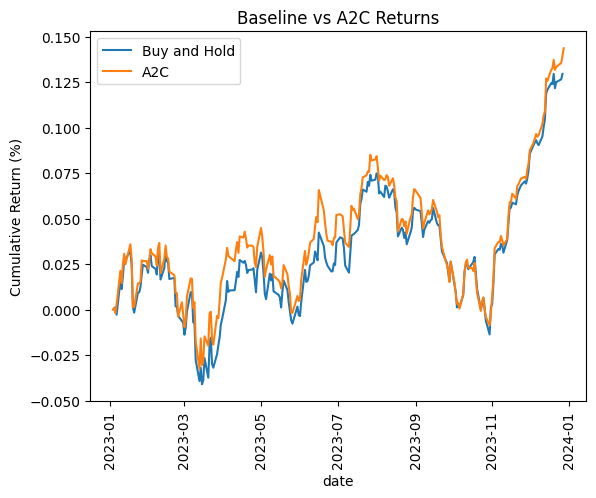

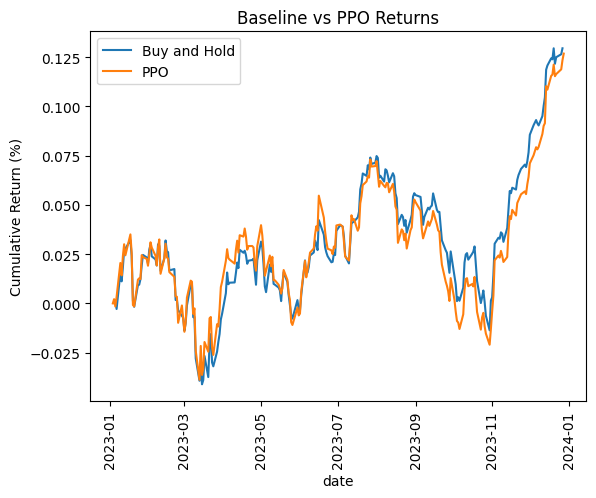

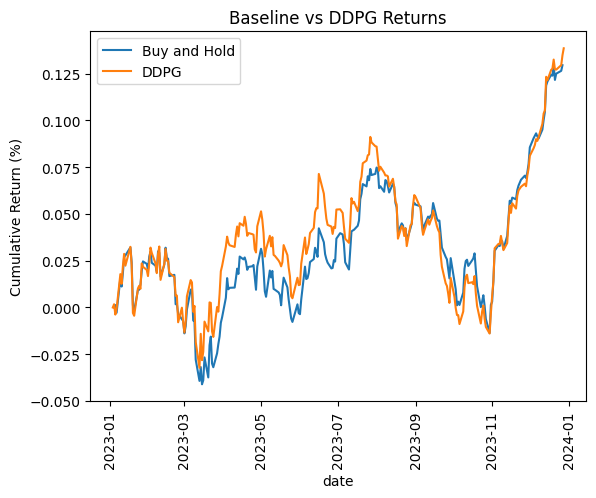

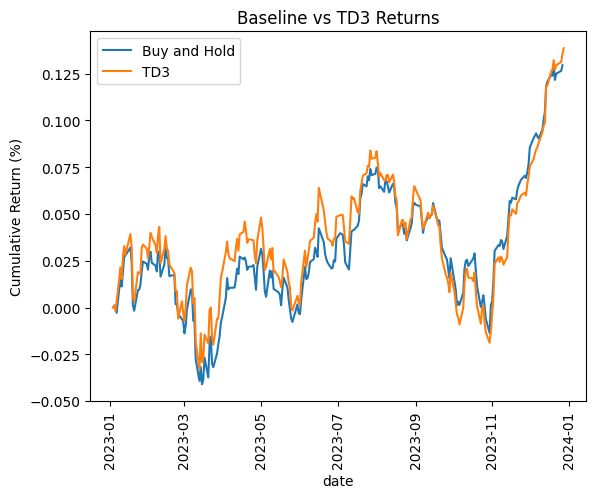

In [26]:
%matplotlib inline
def plot_returns(df_base, df_model, model_name):
    plt.plot(df_base['date'], df_base['daily_return'].cumsum(), label='Buy and Hold')
    plt.plot(df_model['date'],  df_model['daily_return'].cumsum(),  label=model_name)
    plt.title(f'Baseline vs {model_name} Returns')
    plt.ylabel('Cumulative Return (%)')
    plt.xlabel('date')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

plot_returns(baseline_returns, df_a2c, 'A2C')
plot_returns(baseline_returns, df_ppo, 'PPO')
plot_returns(baseline_returns, df_ddpg, 'DDPG')
plot_returns(baseline_returns, df_td3, 'TD3')